# Partitioning and Tokenization Analysis

In [1]:
from collections import Counter
from datasets import Dataset
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner, PathologicalPartitioner
from flwr_datasets.visualization import plot_label_distributions
from transformers import AutoTokenizer, PreTrainedTokenizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
num_partitions = 4

## Data Preprocessing

In [3]:
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
}

In [4]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
def preprocess_data(frame: pd.DataFrame) -> pd.DataFrame:
    copied = (frame[["sentence", "gold_label"]]
              .rename(columns={"sentence": "text", "gold_label": "label"}))
    copied = copied[copied.label != "mixed"].dropna()
    copied["label"] = copied["label"].map(label_mapping)

    return copied

In [6]:
def tokenize_data(ds: Dataset, tokenizer: PreTrainedTokenizer) -> Dataset:
    copied = ds.map(
        lambda s, tok: {
            "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
            "attention_mask": encoded["attention_mask"],
        },
        fn_kwargs={"tok": tokenizer},
    )

    return copied

In [7]:
training_data = (preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-train.jsonl", lines=True))
                 .head(47_800))

validation_data = pd.concat([
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-test.jsonl", lines=True)),
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-dev.jsonl", lines=True)),
], ignore_index=True).drop_duplicates()

In [8]:
training_dataset = Dataset.from_pandas(training_data, preserve_index=False)
validation_dataset = Dataset.from_pandas(validation_data, preserve_index=False)

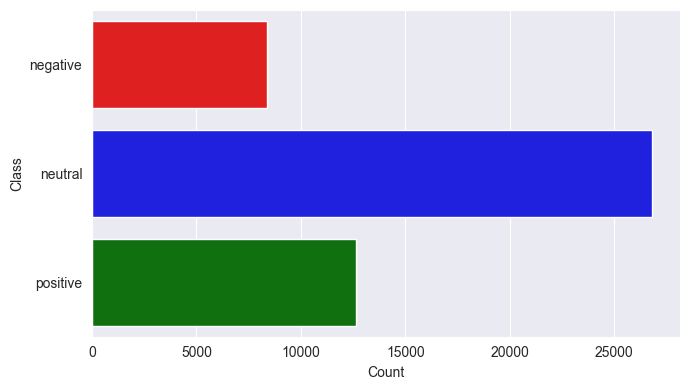

In [9]:
label_counts = training_data["label"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
ax = sns.barplot(x=label_counts.values, y=label_counts.index, orient="h", palette=["red", "blue", "green"], hue=label_counts.index, legend=False)

plt.xlabel("Count")
plt.ylabel("Class")

ax.set_yticks(range(len(label_mapping)))
ax.set_yticklabels([{value: key for key, value in label_mapping.items()}[i] for i in sorted(label_mapping.values())])

plt.tight_layout()
plt.show()

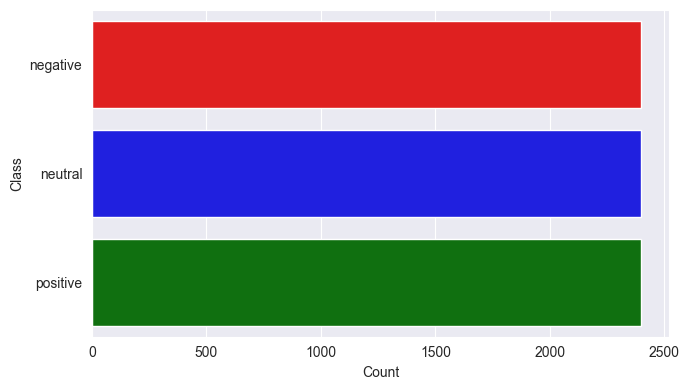

In [10]:
label_counts = validation_data["label"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
ax = sns.barplot(x=label_counts.values, y=label_counts.index, orient="h", palette=["red", "blue", "green"], hue=label_counts.index, legend=False)

plt.xlabel("Count")
plt.ylabel("Class")

ax.set_yticks(range(len(label_mapping)))
ax.set_yticklabels([{value: key for key, value in label_mapping.items()}[i] for i in sorted(label_mapping.values())])

plt.tight_layout()
plt.show()

## Partitioning
### IID Partitioner

In [44]:
iid_partitioner = IidPartitioner(num_partitions=num_partitions)
iid_partitioner.dataset = training_dataset

C:\Users\ileuk\IdeaProjects\2024-Oksanich-NLI-VFL\venv\Lib\site-packages\flwr_datasets\metrics\utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


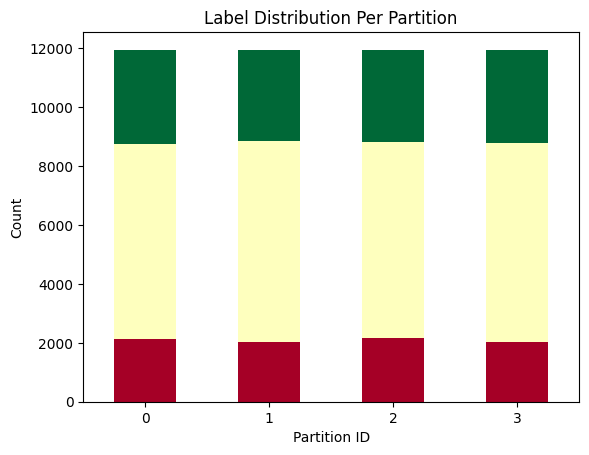

In [49]:
fig, ax, df = plot_label_distributions(
    iid_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    title="Label Distribution Per Partition",
)

In [ ]:
for i in range(num_partitions):
    partition = iid_partitioner.load_partition(i)
    partition_df = partition.to_pandas()
    partition_df.to_json(f"data/partitions/iid_partition_{i}.jsonl", lines=True, orient="records")

### Dirichlet Partitioner

In [31]:
dirichlet_partitioner = DirichletPartitioner(num_partitions=num_partitions, alpha=2.0, partition_by="label")
dirichlet_partitioner.dataset = training_dataset

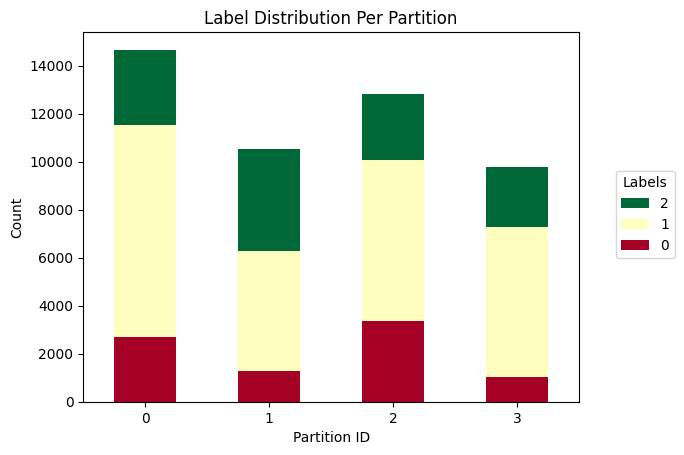

In [32]:
fig, ax, df = plot_label_distributions(
    dirichlet_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    title="Label Distribution Per Partition",
)

In [ ]:
for i in range(num_partitions):
    partition = dirichlet_partitioner.load_partition(i)
    partition_df = partition.to_pandas()
    partition_df.to_json(f"data/partitions/dirichlet_partition_{i}.jsonl", lines=True, orient="records")

### Dirichlet Partitioner (Self-Balancing)

In [50]:
dirichlet_partitioner_balanced = DirichletPartitioner(num_partitions=num_partitions, alpha=2.0, partition_by="label", self_balancing=True)
dirichlet_partitioner_balanced.dataset = training_dataset

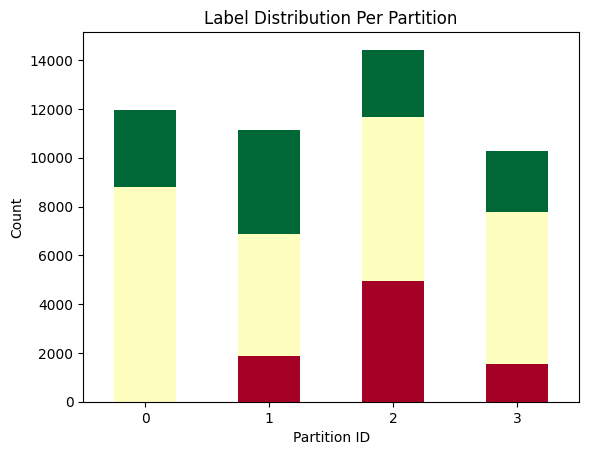

In [51]:
fig, ax, df = plot_label_distributions(
    dirichlet_partitioner_balanced,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    title="Label Distribution Per Partition",
)

In [55]:
for i in range(num_partitions):
    partition = dirichlet_partitioner_balanced.load_partition(i)
    partition_df = partition.to_pandas()
    partition_df.to_json(f"data/partitions/balanced_dirichlet_partition_{i}.jsonl", lines=True, orient="records")

### Pathological Partitioner (First Deterministic)

In [15]:
path_partitioner = PathologicalPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    num_classes_per_partition=3,
    class_assignment_mode="first-deterministic"
)
path_partitioner.dataset = training_dataset

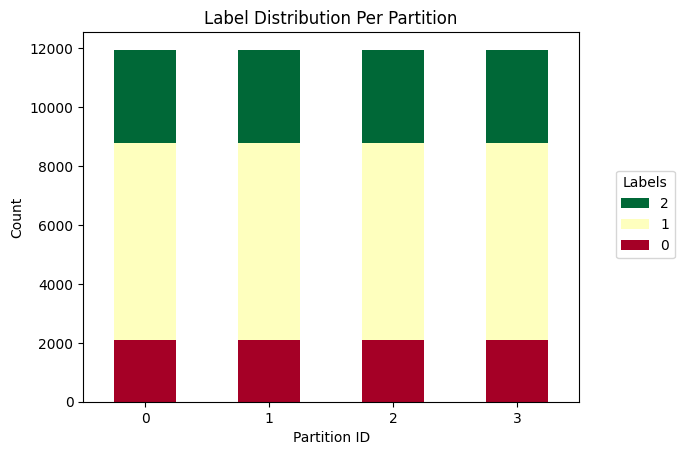

In [16]:
fig, ax, df = plot_label_distributions(
    path_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    title="Label Distribution Per Partition",
)

In [ ]:
for i in range(num_partitions):
    partition = path_partitioner.load_partition(i)
    partition_df = partition.to_pandas()
    partition_df.to_json(f"data/partitions/pathological_partition_{i}.jsonl", lines=True, orient="records")

### Pathological Partitioner (Deterministic)

In [17]:
path_partitioner_deter = PathologicalPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    num_classes_per_partition=3,
    class_assignment_mode="deterministic"
)
path_partitioner_deter.dataset = training_dataset

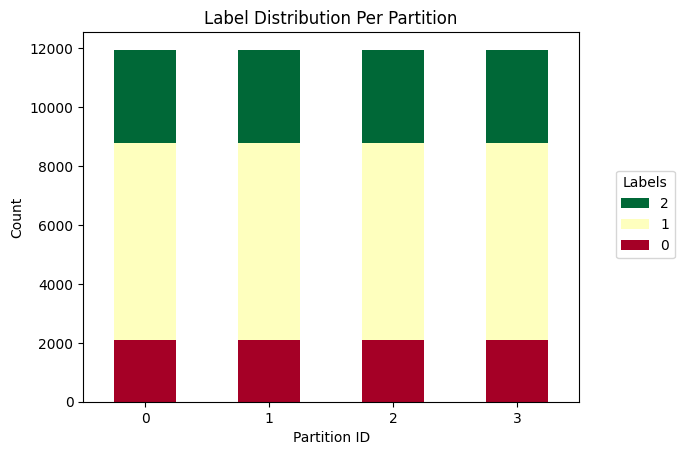

In [18]:
fig, ax, df = plot_label_distributions(
    path_partitioner_deter,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    title="Label Distribution Per Partition",
)

In [ ]:
for i in range(num_partitions):
    partition = path_partitioner_deter.load_partition(i)
    partition_df = partition.to_pandas()
    partition_df.to_json(f"data/partitions/deter_pathological_partition_{i}.jsonl", lines=True, orient="records")

## Tokenization Analysis

In [31]:
tokenized_train = tokenize_data(training_dataset, distilbert_tokenizer)
tokenized_validation = tokenize_data(validation_dataset, distilbert_tokenizer)

Map:   0%|          | 0/47800 [00:00<?, ? examples/s]

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

In [32]:
token_count = tokenized_train.to_pandas()["ids"].map(lambda x: len(x))

In [33]:
token_count.describe()

count    47800.000000
mean        18.624874
std         10.870517
min          3.000000
25%         11.000000
50%         17.000000
75%         23.000000
max        512.000000
Name: ids, dtype: float64

In [34]:
all_tokens = np.concatenate(tokenized_train.to_pandas()["ids"].values)
unique_tokens = np.unique(all_tokens)

In [35]:
len(unique_tokens)

15694

In [36]:
token_counter = Counter(all_tokens)
common_tokens = token_counter.most_common(100)

In [37]:
[(token_id, distilbert_tokenizer.decode(token_id), n) for token_id, n in common_tokens]

[(1012, '.', 48873),
 (101, '[CLS]', 47800),
 (102, '[SEP]', 47800),
 (1996, 'the', 28463),
 (1045, 'i', 23111),
 (1998, 'and', 19095),
 (1010, ',', 18174),
 (1037, 'a', 18071),
 (2000, 'to', 17955),
 (1005, "'", 12081),
 (2001, 'was', 9480),
 (2009, 'it', 8869),
 (1997, 'of', 8811),
 (2005, 'for', 8691),
 (1999, 'in', 8338),
 (2026, 'my', 7870),
 (2057, 'we', 6809),
 (2008, 'that', 6165),
 (999, '!', 5498),
 (2017, 'you', 5411),
 (2003, 'is', 5368),
 (2006, 'on', 5320),
 (2007, 'with', 5148),
 (2027, 'they', 4885),
 (2023, 'this', 4694),
 (1056, 't', 4442),
 (2018, 'had', 4114),
 (2031, 'have', 4109),
 (2012, 'at', 3931),
 (1055, 's', 3799),
 (1011, '-', 3711),
 (2061, 'so', 3551),
 (2025, 'not', 3533),
 (2015, '##s', 3284),
 (2021, 'but', 3259),
 (2033, 'me', 2970),
 (1000, '"', 2889),
 (2045, 'there', 2867),
 (2020, 'were', 2813),
 (2022, 'be', 2697),
 (2041, 'out', 2654),
 (2004, 'as', 2482),
 (1007, ')', 2480),
 (2065, 'if', 2468),
 (1006, '(', 2389),
 (2024, 'are', 2329),
 (2131,

In [38]:
vocab = distilbert_tokenizer.get_vocab()
total_vocab_size = len(vocab)

In [39]:
coverage = len(unique_tokens) / total_vocab_size * 100
print(f"Vocabulary coverage: {coverage:.2f}%")

Vocabulary coverage: 51.42%


In [40]:
unknown_tokens = np.count_nonzero(all_tokens == distilbert_tokenizer.unk_token_id)
print(f"Unknown tokens: {unknown_tokens}, {unknown_tokens / len(all_tokens) * 100:.2f}%")

Unknown tokens: 480, 0.05%


### Validation Dataset Tokenization

In [41]:
validation_tokens = np.concatenate(tokenized_validation.to_pandas()["ids"].values)
unique_validation_tokens = np.unique(validation_tokens)

In [42]:
len(unique_validation_tokens)

8253

In [30]:
tokenized_validation.to_pandas()["ids"].map(lambda x: len(x)).describe()

count    7200.000000
mean       19.277639
std        10.286249
min         4.000000
25%        12.000000
50%        17.000000
75%        24.000000
max       126.000000
Name: ids, dtype: float64

In [31]:
validation_specific_tokens = np.setdiff1d(unique_validation_tokens, unique_tokens)

In [32]:
len(validation_specific_tokens)

552

In [33]:
token_counter = Counter(validation_specific_tokens)
common_tokens = token_counter.most_common(100)

In [34]:
[(token_id, distilbert_tokenizer.decode(token_id), n) for token_id, n in common_tokens]

[(2837, 'committee', 1),
 (2914, 'academy', 1),
 (2982, 'awards', 1),
 (3187, 'secretary', 1),
 (3285, '1972', 1),
 (3339, '1975', 1),
 (3364, 'actor', 1),
 (3418, 'ancient', 1),
 (3729, 'cd', 1),
 (3840, 'corporation', 1),
 (3883, 'actress', 1),
 (3922, 'appearances', 1),
 (3928, 'powerful', 1),
 (4329, 'revolution', 1),
 (4423, 'expanded', 1),
 (4517, 'nuclear', 1),
 (4849, '1925', 1),
 (5000, 'knight', 1),
 (5037, 'turkish', 1),
 (5125, 'victor', 1),
 (5135, 'minnesota', 1),
 (5406, 'frederick', 1),
 (5424, 'arab', 1),
 (5496, 'accused', 1),
 (5912, 'nelson', 1),
 (5919, 'aspects', 1),
 (6145, 'engineers', 1),
 (6348, 'rhythm', 1),
 (6349, 'initiative', 1),
 (6364, 'processing', 1),
 (6428, 'stronger', 1),
 (6552, 'habitat', 1),
 (6569, 'joy', 1),
 (6579, 'animated', 1),
 (6768, 'delhi', 1),
 (7100, '##hill', 1),
 (7142, 'continuous', 1),
 (7203, 'illustrated', 1),
 (7236, 'categories', 1),
 (7268, 'collective', 1),
 (7271, 'publicly', 1),
 (7272, 'wealthy', 1),
 (7296, 'gregory', 1

In [43]:
coverage = len(unique_validation_tokens) / total_vocab_size * 100
print(f"Vocabulary coverage: {coverage:.2f}%")

Vocabulary coverage: 27.04%


In [35]:
unknown_tokens = np.count_nonzero(validation_tokens == distilbert_tokenizer.unk_token_id)
print(f"Unknown tokens: {unknown_tokens}, {unknown_tokens / len(validation_tokens) * 100:.2f}%")

Unknown tokens: 0, 0.00%
